# Assignment 1

### Executive Summary 

        - Objective (What?): The objective of this project is to predict the revenue per customer for the Google Merchandise Store using a dataset obtained from Google Analytics. The goal is to enable actionable operational changes and optimize marketing budgets through data analysis. 


        - Impact (So What?): Successful prediction of revenue per customer will empower businesses to make informed decisions, enhance operational efficiency, and allocate marketing budgets more effectively. By leveraging insights from the analysis, companies can tailor their strategies to maximize revenue and improve overall performance.


        - Model Context (How?): The model utilizes a dataset obtained from Google Analytics (GStore) to predict the revenue that a customer might generate. The prediction is based on various features and behaviors tracked by Google Analytics on the store's website. 

        
        - Dataset: The dataset used for this project is sourced from Kaggle and specifically focuses on the Google Merchandise Store's customer interactions and transactions. The dataset can be accessed here:https://www.kaggle.com/competitions/ga-customer-revenue-prediction


### Libraries

In [15]:
!pip install -r requirements.txt
import causalml

!pip install tensorflow
# Standard Libraries
import os
import json
import datetime
import time
import itertools
import warnings
import dtale

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
from pandas import json_normalize

# Statistical Analysis
from scipy.stats import kurtosis, skew 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plotly for Interactive Visualization
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
import squarify


# Machine Learning Libraries
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# LightGBM, XGBoost, CatBoost for Gradient Boosting
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Other Utilities
import gc
from IPython.display import HTML
import shap

# Jupyter Notebook Setup
%matplotlib inline
py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# pipeline
#Transformation pipeline
from sklearn.pipeline import Pipeline
# imputer kmeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

warnings.filterwarnings('ignore')
gc.enable()

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
  Using cached tensorflow-2.15.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached tensorflow_macos-2.15.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metada

ModuleNotFoundError: No module named 'catboost'

### Functions

In [ ]:
dtypes = {
    "fullVisitorId": str, "channelGrouping": str, "date": str, "device": str, "geoNetwork": str,
    "socialEngagementType": str, "totals": str, "trafficSource": str, "visitId": int, "visitNumber": int,
    "visitStartTime": int, "hits": str, "customDimensions": str }
    

def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype=dtypes,
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

def clean_datatypes(df):
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.datetime.fromtimestamp(x).hour))).astype(int)
    #drop visitStartTime
    df.drop(['visitStartTime'], axis=1, inplace=True)

    return df

def missing_data_analysis(df):
    # new data frame to have column names, count of blank rows, null values and percentage of null values, count of 'not available in dataset' values and percentage of 'not available in dataset' values
    missing_data = pd.DataFrame({'column_name': df.columns,
                                 'blank_rows': df.isnull().sum(),
                                 'null_values': df.isna().sum(),
                                 'percentage_null_values': df.isna().sum() / df.shape[0] * 100,
                                 'not_available_in_ds': df.isin(['not available in demo dataset']).sum(),
                                 'percentage_not_available': df.isin(['not available in demo dataset']).sum() / df.shape[0] * 100})
    # sort by percentage blank rows descending
    # remove index
    missing_data.reset_index(drop=True, inplace=True)
    missing_data.sort_values('percentage_null_values', inplace=True, ascending=False)
    display(missing_data)


def Fixing_Blanks_Nulls(df):

    
    df['totals.transactionRevenue'] = df['totals.transactionRevenue']*0.0000010
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0)
    
    df['totals.pageviews'].fillna(1, inplace=True)
    df['totals.pageviews'] = df['totals.pageviews'].astype(int)
    df['totals.newVisits'].fillna(0, inplace=True)
    df['totals.newVisits'] = df['totals.newVisits'].astype(int)
    df['totals.bounces'].fillna(0, inplace=True)
    df['totals.bounces'] = df['totals.bounces'].astype(int)
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float)
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True)
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
    
    df.loc[df['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
    df['totals.pageviews'].fillna(1, inplace=True)  # filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True)  # filling NA's with 0
    df['totals.bounces'].fillna(0, inplace=True)  # filling NA's with 0
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True)  # filling boolean with False
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)  # filling boolean with True
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float)  # filling NA with zero
    df['totals.pageviews'] = df['totals.pageviews'].astype(int)  # setting numerical column as integer
    df['totals.newVisits'] = df['totals.newVisits'].astype(int)  # setting numerical column as integer
    df['totals.bounces'] = df['totals.bounces'].astype(int)  # setting numerical column as integer
    df["totals.hits"] = df["totals.hits"].astype(float)  # setting numerical to float
    df['totals.visits'] = df['totals.visits'].astype(int)  # setting as int

    to_drop = ["socialEngagementType", 'device.browserVersion', 'device.browserSize', 'device.flashVersion',
               'device.language',
               'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
               'device.mobileDeviceModel',
               'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors',
               'device.screenResolution',
               'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation',
               'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.gclId',
               'trafficSource.campaign', 'trafficSource.campaignCode',
               'trafficSource.adwordsClickInfo.page', 'trafficSource.referralPath',
               'trafficSource.adwordsClickInfo.slot',
               'trafficSource.adContent', 'trafficSource.keyword', 'trafficSource.adwordsClickInfo.adNetworkType']

    to_drop = [col for col in to_drop if col in df.columns]
    df = df.drop(to_drop, axis=1)
    return df

null = []

def removing_redundant_columns(df):
    # drop columns with only one unique value
    for n in df.columns:
        if df[n].nunique(dropna=False) == 1:
            null.append(n)
    columns_to_drop = null
    df.drop(columns=columns_to_drop, inplace=True)
    df.head()
    return df

def CalcOutliers(df_num): 
    '''
    Set a numerical value and it will calculate the upper, lower and total number of outliers
    It will print a lot of statistics of the numerical feature that you set on input
    '''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Identified outliers: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return



def Normalizing(df):
    # Use MinMaxScaler to normalize the column
    df["totals.hits"] =  (df['totals.hits'] - min(df['totals.hits'])) / (max(df['totals.hits'])  - min(df['totals.hits']))
    # normalizing the transaction Revenue
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(lambda x: np.log1p(x))
    # return the modified df
    return df

def univar_analysis(df):
    # display train_df.describe().T as a  table with title 'Univariate Analysis of numerical columns'
    from IPython.display import display, HTML
    display(HTML('<h1>Univariate Analysis of numerical columns</h1>'))
    display(df.describe().T)
    display(HTML('<h1>Univariate Analysis of categorical columns</h1>'))
    display(df.describe(include=['object']).transpose())
    # Univariant Analysis of datetime columns
    display(HTML('<h1>Univariate Analysis of datetime columns</h1>'))
    display(df.describe(include=['datetime64[ns]']).transpose())
    # Univariant Analysis of boolean columns
    display(HTML('<h1>Univariate Analysis of boolean columns</h1>'))
    display(df.describe(include=['bool']).transpose())

def rev_dsitrbn(df):
    # distribution plot with plotly
    filtered_df = df[(df['totals.transactionRevenue'] > 0)]
    fig = px.histogram(filtered_df, x="totals.transactionRevenue", nbins=15, title='Distribution of revenue where revenue is not zero')
    fig.show()
    sns.distplot(df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])
    plt.title("Distribution of revenue where revenue is not zero", fontsize=14)
    plt.xlabel("Revenue", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.show()

def rev_log_distbn(df):
        # Printing some statistics of our data
    print("Transaction Revenue Min Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].min()) # printing the min value
    print("Transaction Revenue Mean Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].mean()) # mean value
    print("Transaction Revenue Median Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].median()) # median value
    print("Transaction Revenue Max Value: ", 
        df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].max()) # the max value

    # It I did to plot the quantiles but are not working
    #print(round(df['totals.transactionRevenue'].quantile([.025,.25,.5,.75,.975]),2))

    # seting the figure size of our plots
    plt.figure(figsize=(14,5))

    # Subplot allow us to plot more than one 
    # in this case, will be create a subplot grid of 2 x 1
    plt.subplot(1,2,1)
    # seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
    # also, we will set the number of bins and if we want or not kde on our histogram
    ax = sns.distplot(np.log(df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"] + 0.01), bins=40, kde=True)
    ax.set_xlabel('Transaction RevenueLog', fontsize=15) #seting the xlabel and size of font
    ax.set_ylabel('Distribuition', fontsize=15) #seting the ylabel and size of font
    ax.set_title("Distribuition of Revenue Log", fontsize=20) #seting the title and size of font

    # setting the second plot of our grid of graphs
    plt.subplot(1,2,2)
    # ordering the total of users and seting the values of transactions to understanding 
    plt.scatter(range(df.shape[0]), np.sort(df['totals.transactionRevenue'].values))
    plt.xlabel('Index', fontsize=15) # xlabel and size of words
    plt.ylabel('Revenue value', fontsize=15) # ylabel and size of words
    plt.title("Revenue Value Distribution", fontsize=20) # Setting Title and fontsize

    plt.show()

    print('Excess kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])))
    print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew((df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))))


def bivariate_analysis(df):
    plt.figure(figsize=(13,6)) #figure size

    #It's another way to plot our data. using a variable that contains the plot parameters
    g1 = sns.boxenplot(x='device.browser', y='totals.transactionRevenue', 
                    data=df[(df['device.browser'].isin((df['device.browser'].value_counts()[:10].index.values))) &
                                    df['totals.transactionRevenue'] > 0])
    g1.set_title('Browsers Name by Transactions Revenue', fontsize=20) # title and fontsize
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
    g1.set_xlabel('Device Names', fontsize=18) # Xlabel
    g1.set_ylabel('Trans Revenue(log) Dist', fontsize=18) #Ylabel

    plt.show()

    # the top 5 of browsers represent % of total
    print("Percentual of Operational System: ")
    print(df['device.operatingSystem'].value_counts()[:5]) # printing the top 7 percentage of browsers

    # seting the graph size
    plt.figure(figsize=(14,7))

    # let explore the browser used by users
    sns.countplot(data = df, x = "device.operatingSystem", palette="hls") # It's a module to count the category's
    plt.title("Operational System used Count", fontsize=20) # seting the title size
    plt.xlabel("Operational System Name", fontsize=16) # seting the x label size
    plt.ylabel("OS Count", fontsize=16) # seting the y label size
    plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

    plt.show() #use plt.show to render the graph that we did above


    (sns.FacetGrid(df[(df['device.operatingSystem']\
                            .isin(df['device.operatingSystem']\
                                .value_counts()[:6].index.values)) & df['totals.transactionRevenue'] > 0],
                hue='device.operatingSystem', height=5, aspect=2)
    .map(sns.kdeplot, 'totals.transactionRevenue', shade=True)
    .add_legend()
    )
    plt.show()

    # the top 5 of browsers represent % of total
    print("Percentual of Operational System: ")
    print(round(df['device.deviceCategory'].value_counts() / len(df['device.deviceCategory']) * 100, 2)) # printing the top 7 percentage of browsers

    # seting the graph size
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    # let explore the browser used by users
    sns.countplot(data = df, x = "device.deviceCategory", palette="hls") # It's a module to count the category's
    plt.title("Device Category Count", fontsize=20) # seting the title size
    plt.xlabel("Device Category", fontsize=18) # seting the x label size
    plt.ylabel("Count", fontsize=16) # seting the y label size
    plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

    plt.subplot(1,2,2)
    sns.boxenplot(x="device.deviceCategory", y = 'totals.transactionRevenue', 
                data=df[df['totals.transactionRevenue'] > 0], palette="hls") # It's a module to count the category's
    plt.title("Device Category Revenue Distribuition", fontsize=20) # seting the title size
    plt.xlabel("Device Category", fontsize=18) # seting the x label size
    plt.ylabel("Revenue(Log)", fontsize=16) # seting the y label size
    plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

    plt.subplots_adjust(hspace = 0.9, wspace = 0.5)

    plt.show() #use plt.show to render the graph that we did above

    (sns.FacetGrid(df[df['totals.transactionRevenue'] > 0],
                hue='device.deviceCategory', height=5, aspect=2)
    .map(sns.kdeplot, 'totals.transactionRevenue', shade=True)
    .add_legend()
    )
    plt.show()

    # At index I will use set my variable that I want analyse and cross by another
    crosstab_eda = pd.crosstab(index=df['channelGrouping'], normalize=True,
                            # at this line, I am using the isin to select just the top 5 of browsers
                            columns=df[df['device.browser'].isin(df['device.browser']\
                                                                                .value_counts()[:5].index.values)]['device.browser'])
    # Ploting the crosstab that we did above
    crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                    figsize=(14,7), # adjusting the size of graphs
                    stacked=True)   # code to unstack 
    plt.title("Channel Grouping % for which Browser", fontsize=20) # seting the title size
    plt.xlabel("The Channel Grouping Name", fontsize=18) # seting the x label size
    plt.ylabel("Count", fontsize=18) # seting the y label size
    plt.xticks(rotation=0)
    plt.show() # rendering

    # At index I will use isin to substitute the loop and get just the values with more than 1%
    crosstab_eda = pd.crosstab(index=df['device.deviceCategory'], # at this line, I am using the isin to select just the top 5 of browsers
                            columns=df[df['device.operatingSystem']\
                                                .isin(df['device.operatingSystem']\
                                                    .value_counts()[:6].index.values)]['device.operatingSystem'])
    # Ploting the crosstab that we did above
    crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                    figsize=(14,7), # adjusting the size of graphs
                    stacked=True)   # code to unstack 
    plt.title("Most frequent OS's by Device Categorys of users", fontsize=22) # adjusting title and fontsize
    plt.xlabel("Device Name", fontsize=19)                # adjusting x label and fontsize
    plt.ylabel("Count Device x OS", fontsize=19)                               # adjusting y label and fontsize
    plt.xticks(rotation=0)                                            # Adjust the xticks, rotating the labels


    plt.show() # rendering

    # At index I will use isin to substitute the loop and get just the values with more than 1%
    crosstab_eda = pd.crosstab(index=df[df['geoNetwork.subContinent']\
                                            .isin(df['geoNetwork.subContinent']\
                                                    .value_counts()[:10].index.values)]['geoNetwork.subContinent'], 
                            
                            # at this line, I am using the isin to select just the top 5 of browsers
                            columns=df[df['device.browser'].isin(df['device.browser']\
                                                                                .value_counts()[:5].index.values)]['device.browser'])
    # Ploting the crosstab that we did above
    crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                    figsize=(16,7), # adjusting the size of graphs
                    stacked=True)   # code to unstack 
    plt.title("TOP 10 Most frequent Subcontinents by Browsers used", fontsize=22) # adjusting title and fontsize
    plt.xlabel("Subcontinent Name", fontsize=19) # adjusting x label and fontsize
    plt.ylabel("Count Subcontinent", fontsize=19) # adjusting y label and fontsize
    plt.xticks(rotation=45) # Adjust the xticks, rotating the labels
    plt.legend(loc=1, prop={'size': 12}) # to 

    plt.show() # rendering

def timerelated_fields(df):
    year = df['_year'].value_counts()         # counting the Year with value counts
    month = df['_month'].value_counts()      # coutning months
    weeday = df['_weekday'].value_counts()    # Couting weekday
    day = df['_day'].value_counts()              # counting Day
    date = df['date'].value_counts()           # Counting date
    return df



def interactive_business_viz(df):
    #seting some static color options
    color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
                '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
                '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

    # Visits by time train

    # couting all entries by date to get number of visits by each date
    dates_temp = df['date'].value_counts().to_frame().reset_index().sort_values('index') 
    # renaming the columns to apropriate names
    dates_temp = dates_temp.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})

    # creating the first trace with the necessary parameters
    trace = go.Scatter(x=dates_temp.date.astype(str), y=dates_temp.visits,
                        opacity = 0.8, line = dict(color = color_op[3]), name= 'Visits by day')

    # Below we will get the total values by Transaction Revenue Log by date
    dates_temp_sum = df.groupby('date')['totals.transactionRevenue'].sum().to_frame().reset_index()

    # using the new dates_temp_sum we will create the second trace
    trace1 = go.Scatter(x=dates_temp_sum.date.astype(str), line = dict(color = color_op[1]), name="RevenueLog by day",
                            y=dates_temp_sum['totals.transactionRevenue'], opacity = 0.8)

    # Getting the total values by Transactions by each date
    dates_temp_count = df[df['totals.transactionRevenue'] > 0].groupby('date')['totals.transactionRevenue'].count().to_frame().reset_index()

    # using the new dates_temp_count we will create the third trace
    trace2 = go.Scatter(x=dates_temp_count.date.astype(str), line = dict(color = color_op[5]), name="Sellings by day",
                            y=dates_temp_count['totals.transactionRevenue'], opacity = 0.8)

    #creating the layout the will allow us to give an title and 
    # give us some interesting options to handle with the outputs of graphs
    layout = dict(
        title= "Informations by Date",
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=3, label='3m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(visible = True),
            type='date'
        )
    )

    # creating figure with the both traces and layout
    fig = dict(data= [trace, trace1, trace2], layout=layout)

    #rendering the graphs
    iplot(fig) #it's an equivalent to plt.show()

    country_tree = df["geoNetwork.country"].value_counts() #counting the values of Country

    print("Description most frequent countrys: ")
    print(country_tree[:15]) #printing the 15 top most 

    country_tree = round((df["geoNetwork.country"].value_counts()[:30] \
                        / len(df['geoNetwork.country']) * 100),2)

    plt.figure(figsize=(14,5))
    g = squarify.plot(sizes=country_tree.values, label=country_tree.index, 
                    value=country_tree.values,
                    alpha=.4)
    g.set_title("'TOP 30 Countrys - % size of total",fontsize=20)
    g.set_axis_off()
    plt.show()

    # Counting total visits by countrys
    countMaps = pd.DataFrame(df['geoNetwork.country'].value_counts()).reset_index()
    countMaps.columns=['country', 'counts'] #renaming columns
    countMaps = countMaps.reset_index().drop('index', axis=1) #reseting index and droping the column

    data = [ dict(
            type = 'choropleth',
            locations = countMaps['country'],
            locationmode = 'country names',
            z = countMaps['counts'],
            text = countMaps['country'],
            autocolorscale = False,
            marker = dict(
                line = dict (
                    color = 'rgb(180,180,180)',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = False,
                tickprefix = '',
                title = 'Number of Visits'),
        ) ]

    layout = dict(
        title = 'Couting Visits Per Country',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    figure = dict( data=data, layout=layout )
    iplot(figure, validate=False, filename='map-countrys-count')

    # I will crete a variable of Revenues by country sum
    sumRevMaps = df[df['totals.transactionRevenue'] > 0].groupby("geoNetwork.country")["totals.transactionRevenue"].count().to_frame().reset_index()
    sumRevMaps.columns = ["country", "count_sales"] # renaming columns
    sumRevMaps = sumRevMaps.reset_index().drop('index', axis=1) #reseting index and drop index column

    data = [ dict(
            type = 'choropleth',
            locations = sumRevMaps['country'],
            locationmode = 'country names',
            z = sumRevMaps['count_sales'],
            text = sumRevMaps['country'],
            autocolorscale = False,
            marker = dict(
                line = dict (
                    color = 'rgb(180,180,180)',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = False,
                tickprefix = '',
                title = 'Count of Sales'),
        ) ]

    layout = dict(
        title = 'Total Sales by Country',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    figure = dict( data=data, layout=layout )

    iplot(figure, validate=False, filename='map-countrys-total')


# def label_encoding(df):
#     # label encode the categorical variables and convert the numerical variables to float
#     cat_cols = df.select_dtypes(include=['object']).columns
#     for col in cat_cols:
#         print(col)
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(df[col].values.astype('str')) ) #+ list(test_df[col].values.astype('str'))
#         df[col] = lbl.transform(list(df[col].values.astype('str')))
#         #test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

#     num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']  #  "visitStartTime"
#     for col in num_cols:
#         df[col] = df[col].astype(float)
#         #test_df[col] = test_df[col].astype(float)


def encoders(df):
    to_label_encode = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'trafficSource.source', 'trafficSource.medium']

    for col in to_label_encode:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes

    boolean_to_zeroone = ['device.isMobile', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

    for col in boolean_to_zeroone:
        df[col] = df[col].astype(int)

    return df


# Define a KMeansImputer class
class KMeansImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_impute, n_clusters=5):
        self.features_to_impute = features_to_impute
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        self.kmeans_imputer = KMeans(n_clusters=self.n_clusters)
        self.kmeans_imputer.fit(X[self.features_to_impute].dropna().values.reshape(-1, 1))
        return self

    def transform(self, X):
        for feature in self.features_to_impute:
            missing_values = X[feature].isnull()
            X_missing = X.loc[missing_values, [feature]]

            if not X_missing.empty:
                X.loc[missing_values, feature] = self.kmeans_imputer.predict(X_missing.values.reshape(-1, 1))

        return X

def remove_columns_not_affecting_prediction(df):
    # drop fullvisitorid, sessionid, visitid, visitstarttime, date only if they are present
    to_drop = ["fullVisitorId", "sessionId", "visitId", "visitStartTime", "date"]
    to_drop = [col for col in to_drop if col in df.columns]
    df = df.drop(to_drop, axis=1)
    return df

### 1. Load and Flaten



















































 the dataset (Json -> ingestible format)

#originally run on the full dataset but to save processing time for evaluation, we will run on a subset of the data

In [ ]:
# # Already ran the code to save the time and directly load the flattened file
# train_df = load_df()
# #test_df = load_df("test.csv")
# train_df.to_csv('train_v2.csv', index=False)

ga = pd.read_csv('train_v2.csv', dtype=dtypes, nrows=None)

#running on a subset to increase processing speed
df = ga[ga['totals.transactionRevenue'] > 0]

##full data run (uncomment below and comment above line to run on full data, takes 1-1.5 hours)
#df = ga

ga.shape

(903653, 55)

### 1.2 Cleaning Datatypes

In [ ]:
df = clean_datatypes(df)

### 2. Profiling - PandasProfiling, Dtale and more! 
Dtale was kept in final version of the code as it was able to provide flexibility to variable analysis, \
The results include visibility to distribution, missing values, categorical variable breakdowns and more

In [ ]:
## Option 2 - using dtale
# # dtale

dtale.show(df)
dtale.show(df, export=True)

# Explore Describe data by clciking on the arrow icon on the top left of the table gives insights into correlations,
# missing values, outliers, etc.

### Dtale was found to be much more succint and useful than pandas profiling
### Pandas profiling has been commented out due to superior information of dtale
## Option 1 - using pandas profiling
## profiling using pandas profiling and dtale
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(train_df, minimal = True)
# profile.to_file(output_file="pdprofiling.html")


### 3. Initial Logical Cleeasing
First we can see there's several features in the training set contain null values. Let's compile a list of these features, excluding columns with missing values, as well as those columns have constant values (same values, usually won't give much imformation) throughout the dataset. Also, for sessionId (A unique identifier for this visit to the store) can be removed since it doesn't give any information.

The code below prints out the grouped columns based on their first characters, providing a clearer view of how the columns are distributed alphabetically by their initial letters

In [ ]:
display(HTML("<h1> Missing Data Analysis </h1>"))
missing_data_analysis(df)

df = Fixing_Blanks_Nulls(df)
df = removing_redundant_columns(df)

display(HTML("<h1> Missing Data Analysis Post Cleaning </h1>"))
missing_data_analysis(df)

columns = sorted(df.columns.tolist())
grouped_columns = [list(group) for key, group in itertools.groupby(columns, lambda x: x[0])]

,column_name,blank_rows,null_values,percentage_null_values,not_available_in_ds,percentage_not_available
37,totals.bounces,11515,11515,100,0,0
53,trafficSource.campaignCode,11515,11515,100,0,0
52,trafficSource.adContent,11372,11372,99,0,0
50,trafficSource.adwordsClickInfo.adNetworkType,11061,11061,96,0,0
48,trafficSource.adwordsClickInfo.slot,11061,11061,96,0,0
51,trafficSource.adwordsClickInfo.isVideoAd,11061,11061,96,0,0
47,trafficSource.adwordsClickInfo.page,11061,11061,96,0,0
49,trafficSource.adwordsClickInfo.gclId,11059,11059,96,0,0
43,trafficSource.keyword,7644,7644,66,0,0
38,totals.newVisits,7050,7050,61,0,0


,column_name,blank_rows,null_values,percentage_null_values,not_available_in_ds,percentage_not_available
15,geoNetwork.city,49,49,0,4579,40
1,date,0,0,0,0,0
28,_year,0,0,0,0,0
27,_month,0,0,0,0,0
26,_day,0,0,0,0,0
25,_weekday,0,0,0,0,0
24,trafficSource.adwordsClickInfo.isVideoAd,0,0,0,0,0
23,trafficSource.isTrueDirect,0,0,0,0,0
22,trafficSource.medium,0,0,0,0,0
21,trafficSource.source,0,0,0,0,0


### Initial Business Insights

Only 2 % event contirbute to revenue generation. For our regression model this imbalance suggests use of balancing techniques in the future pipeline

In [2]:
gdf = df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
gdf["totals.transactionRevenue"] = pd.to_numeric(gdf["totals.transactionRevenue"], errors="coerce")
gdf = gdf.dropna(subset=["totals.transactionRevenue"])
gdf["totals.transactionRevenue"] = np.sort(gdf["totals.transactionRevenue"])
total_customers = gdf.shape[0]
revenue_customers = gdf[gdf["totals.transactionRevenue"] > 0].shape[0]
percentage_revenue_customers = (revenue_customers / total_customers) * 100
print("Percentage of customers producing revenue: {:.2f}%".format(percentage_revenue_customers))

NameError: name 'df' is not defined

## Univariate Analysis

In [3]:
# format values 
pd.set_option('display.float_format', lambda x: '%.0f' % x)
univar_analysis(df)

NameError: name 'pd' is not defined

In [4]:
rev_dsitrbn(df)

NameError: name 'rev_dsitrbn' is not defined

In [5]:
df = Normalizing(df)

NameError: name 'Normalizing' is not defined

In [6]:
rev_log_distbn(df)

NameError: name 'rev_log_distbn' is not defined

Our data are fairly symmetrical skewed and have a High Kurtosis.

I will see how many outliers we have on this dataset.

In [7]:
CalcOutliers(df['totals.transactionRevenue'])

NameError: name 'CalcOutliers' is not defined

In [8]:
CalcOutliers(df['totals.pageviews'])

NameError: name 'CalcOutliers' is not defined

In [9]:
# the top 10 browsers represent % of total
print("Percentual of Browser usage: ")
print(df['device.browser'].value_counts()[:7])  # printing the top 7 percentage of browsers

# setting the graph size
plt.figure(figsize=(14, 6))

# Let's explore the browser used by users
top_browsers = df['device.browser'].value_counts()[:10].index
sns.countplot(data=df, x='device.browser', order=top_browsers, palette="hls")  # Use order parameter to display in a specific order
plt.title("TOP 10 Most Frequent Browsers", fontsize=20)
plt.xlabel("Browser Names", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(rotation=45)
plt.show()


Percentual of Browser usage: 


NameError: name 'df' is not defined

In [10]:
# the top 10 of browsers represent % of total
print("Percentual of Channel Grouping used: ")
print((df['channelGrouping'].value_counts()[:5])) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(data = df, x = "channelGrouping", palette="hls") # It's a module to count the category's
plt.title("Channel Grouping Count", fontsize=20) # seting the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show() #use plt.show to render the graph that we did above

Percentual of Channel Grouping used: 


NameError: name 'df' is not defined

## Bi-variate Analysis of the features against the target

In [85]:
# set plot size
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# # plot a grid of beautiful scatter plots of all numerical variables against totals.transactionRevenue
# for i, col in enumerate(num_cols):
#     plt.subplot(3, 3, i+1)
#     plt.scatter(df[col], df['totals.transactionRevenue'])
#     plt.title(col)
#     plt.xlabel(col)
#     plt.ylabel('totals.transactionRevenue')
#     # make charts more spaced
#     plt.subplots_adjust(hspace=0.5)

<Figure size 2000x1000 with 0 Axes>

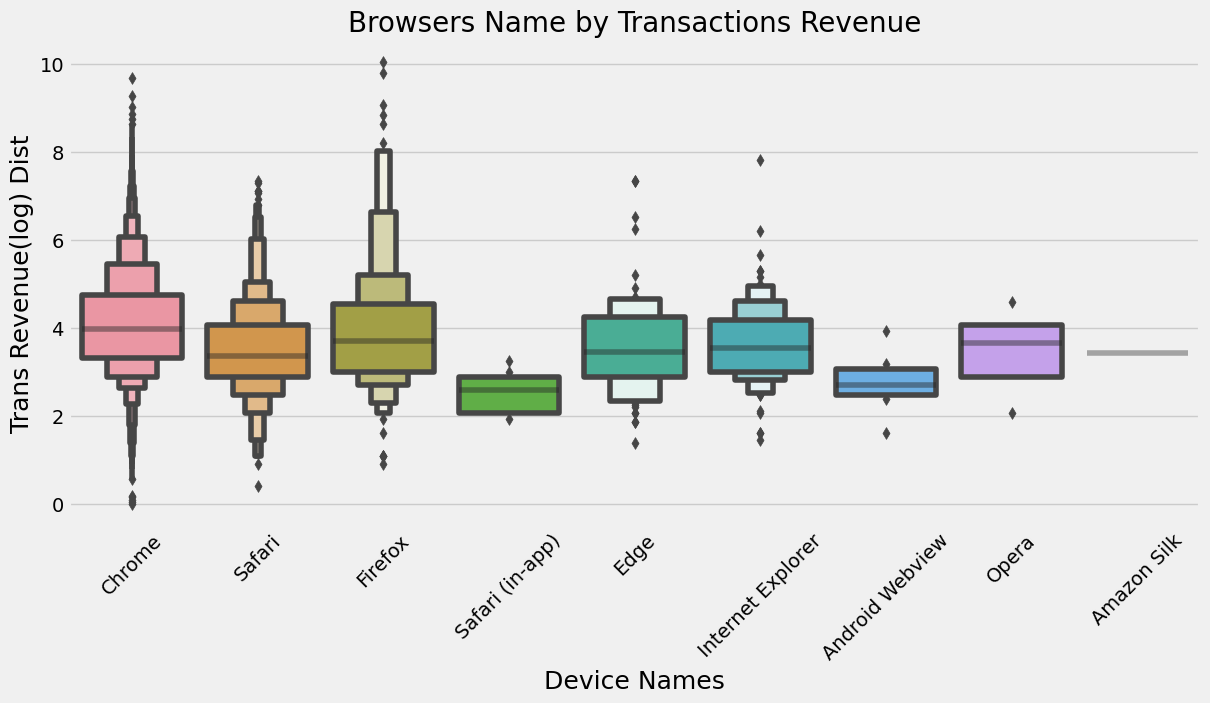

Percentual of Operational System: 
Macintosh    6426
Windows      2309
Chrome OS     994
Linux         782
iOS           536
Name: device.operatingSystem, dtype: int64


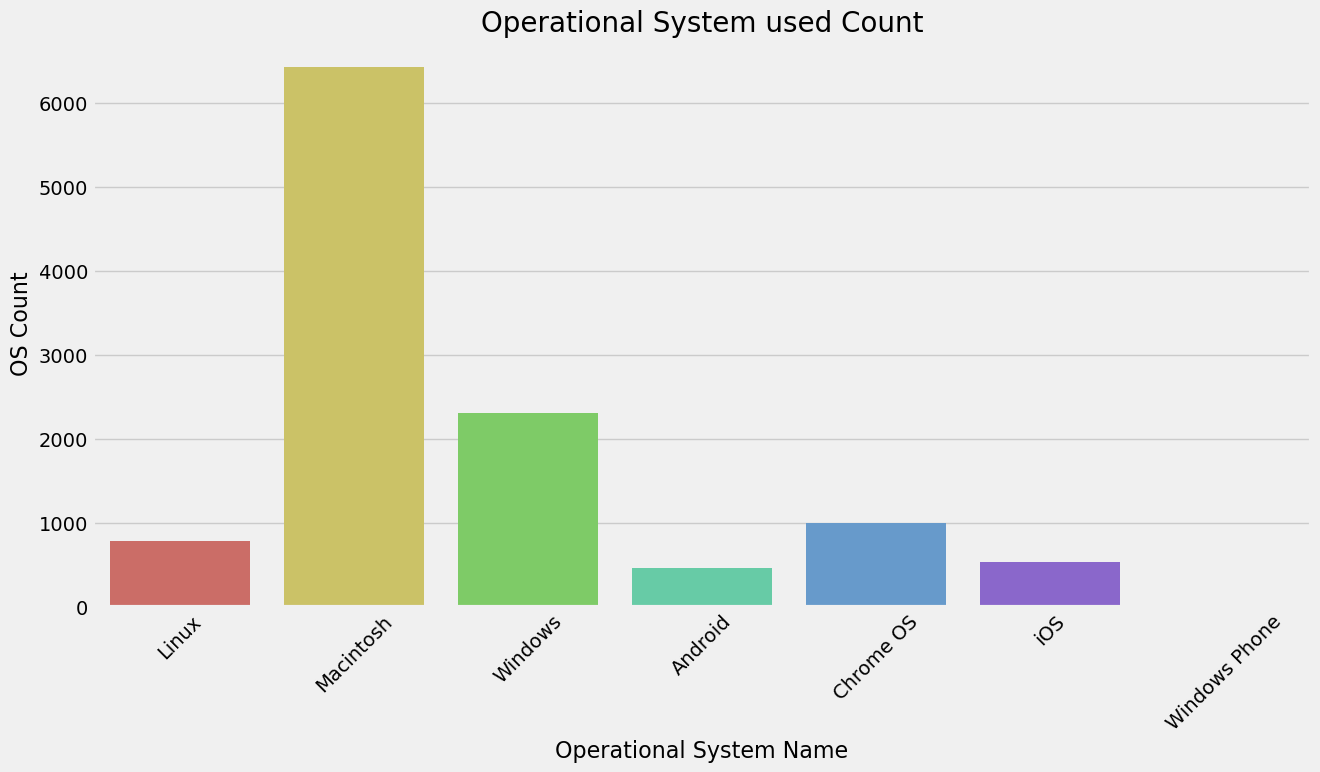

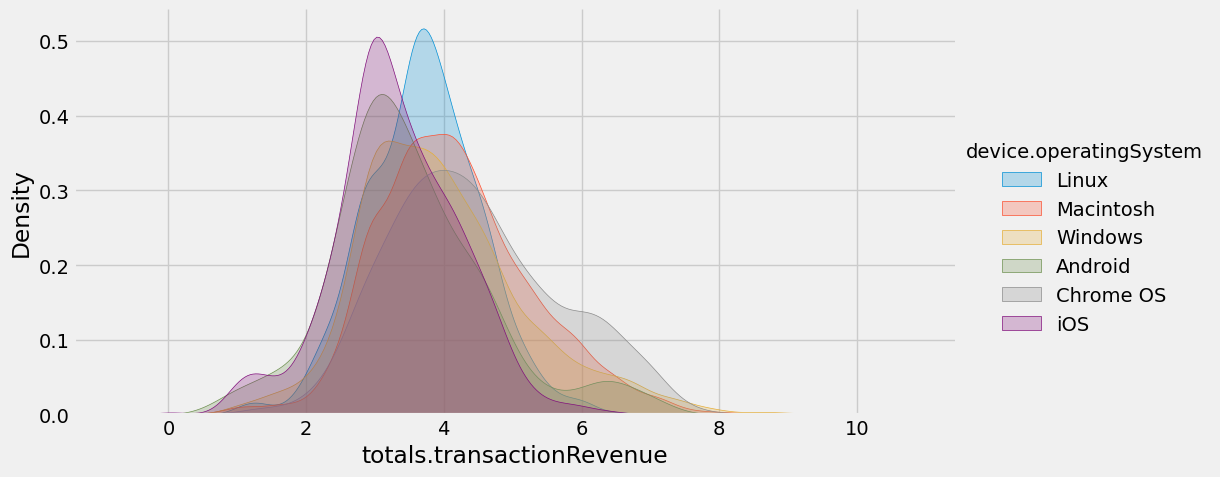

Percentual of Operational System: 
desktop   91
mobile     7
tablet     1
Name: device.deviceCategory, dtype: float64


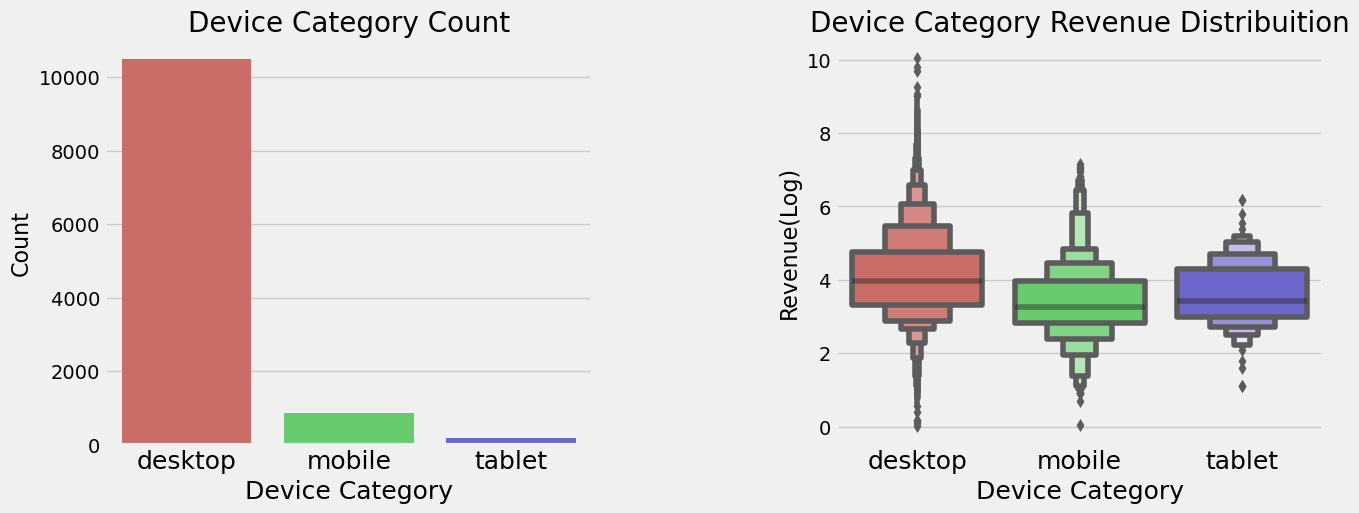

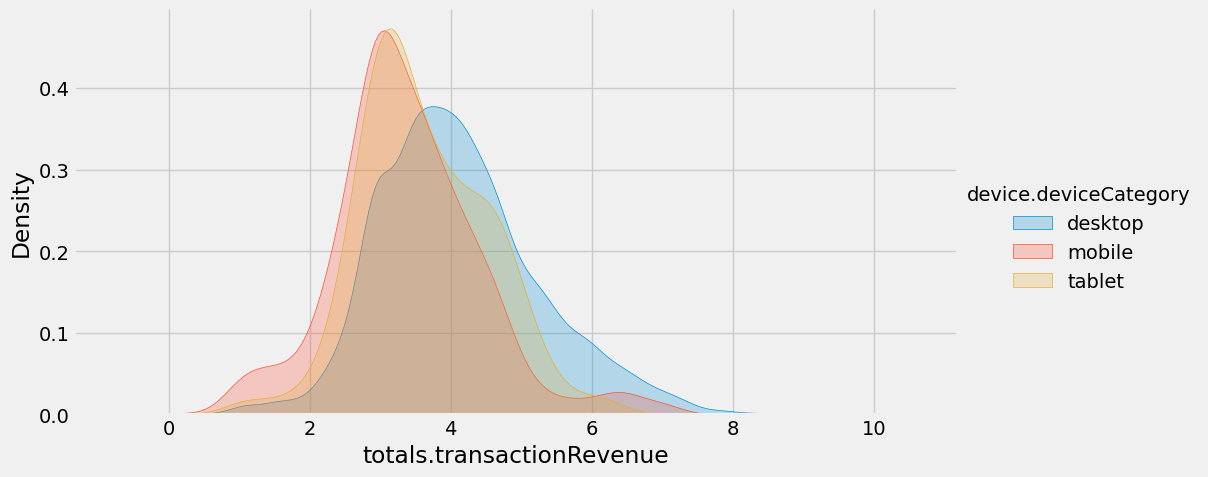

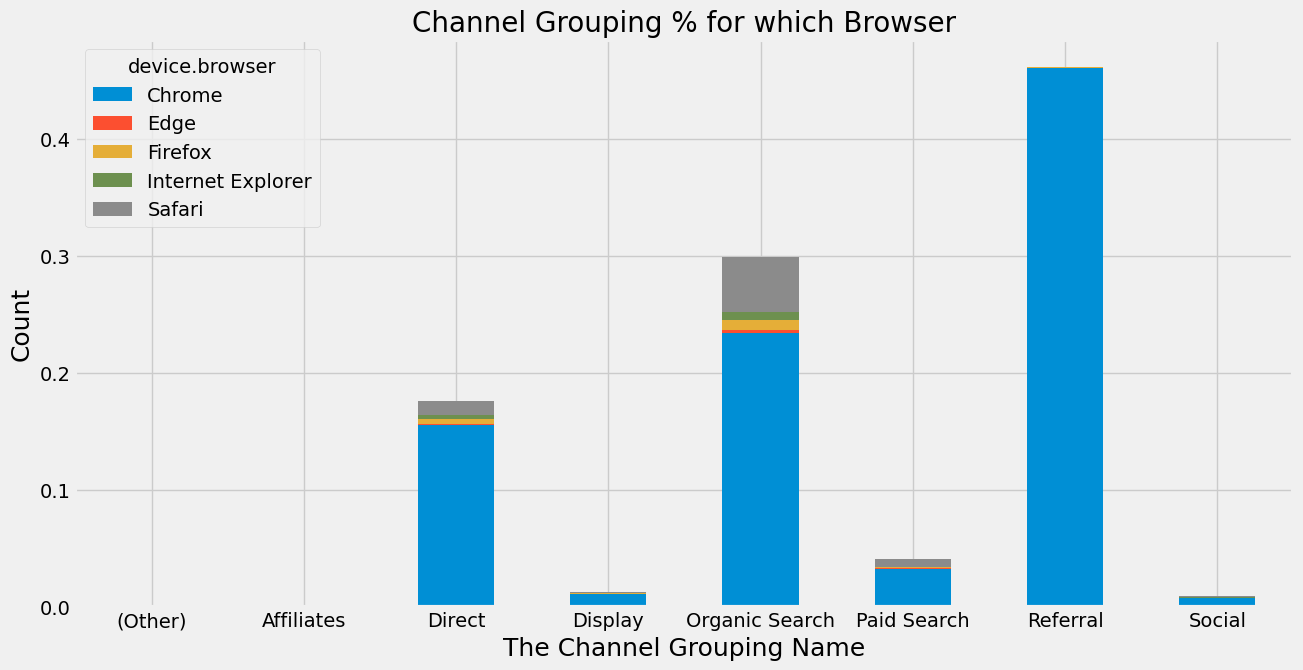

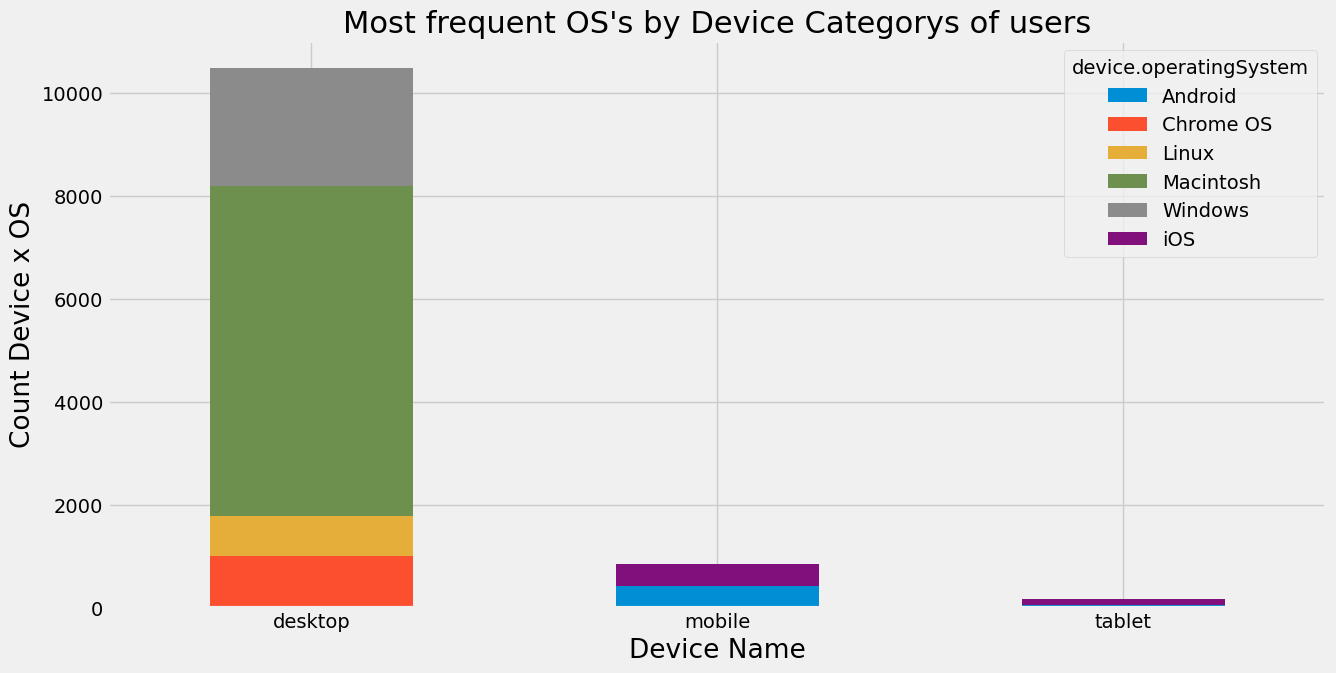

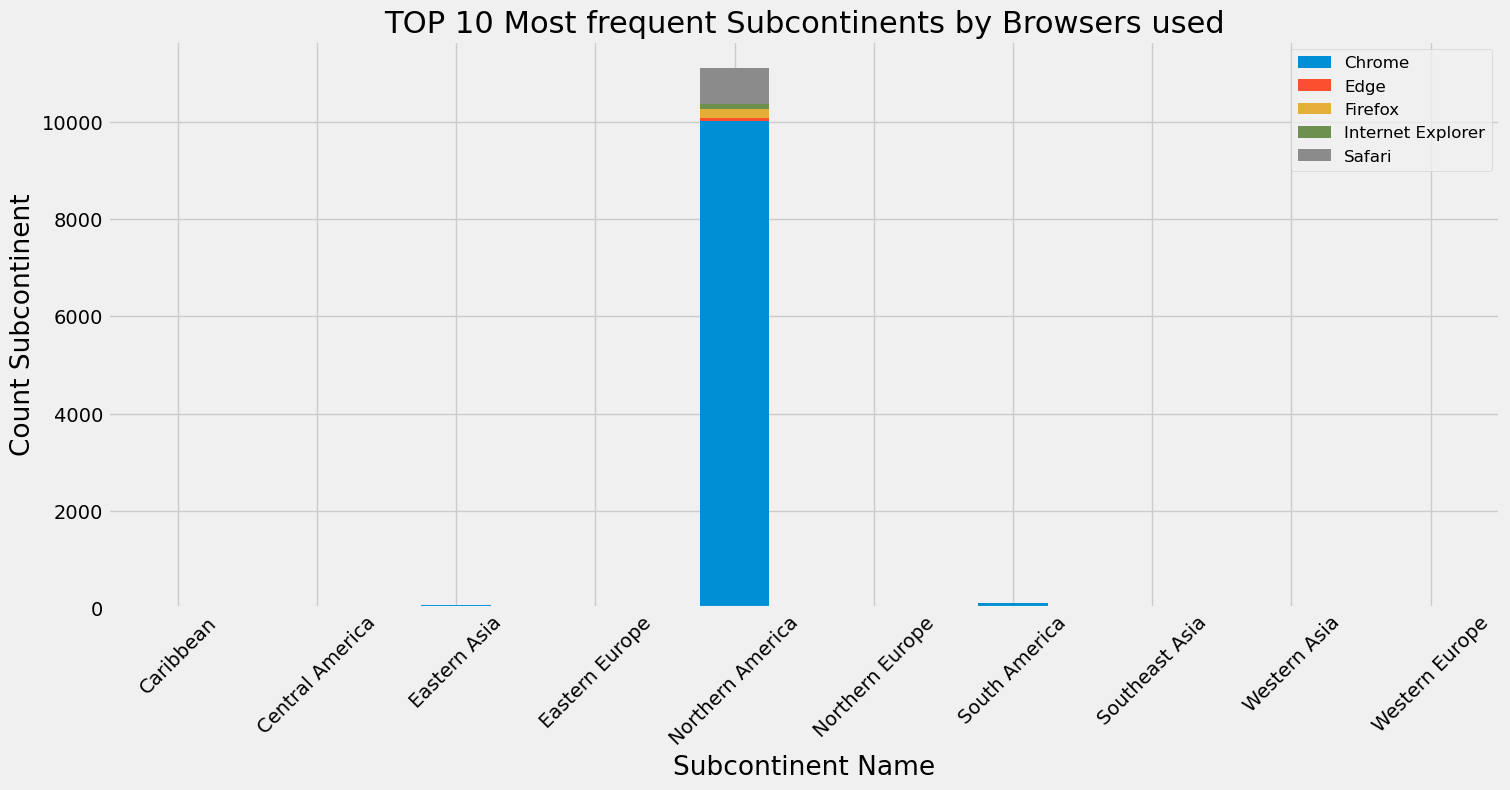

In [86]:
bivariate_analysis(df)

### Missing Information Visualization

In [87]:
# count missing values in each column
df.isnull().sum()

channelGrouping                              0
date                                         0
fullVisitorId                                0
sessionId                                    0
visitId                                      0
visitNumber                                  0
device.browser                               0
device.operatingSystem                       0
device.isMobile                              0
device.deviceCategory                        0
geoNetwork.continent                         0
geoNetwork.subContinent                      0
geoNetwork.country                           0
geoNetwork.region                            0
geoNetwork.metro                             0
geoNetwork.city                             49
geoNetwork.networkDomain                     0
totals.hits                                  0
totals.pageviews                             0
totals.newVisits                             0
totals.transactionRevenue                    0
trafficSource

### Extended EDA for Business

In [88]:
df = timerelated_fields(df)

Description most frequent countrys: 
United States     10953
Canada              190
Venezuela            63
Mexico               20
Taiwan               19
Japan                17
United Kingdom       16
Australia            13
Puerto Rico          11
Indonesia            11
India                10
Singapore            10
Brazil               10
Switzerland           9
Hong Kong             9
Name: geoNetwork.country, dtype: int64


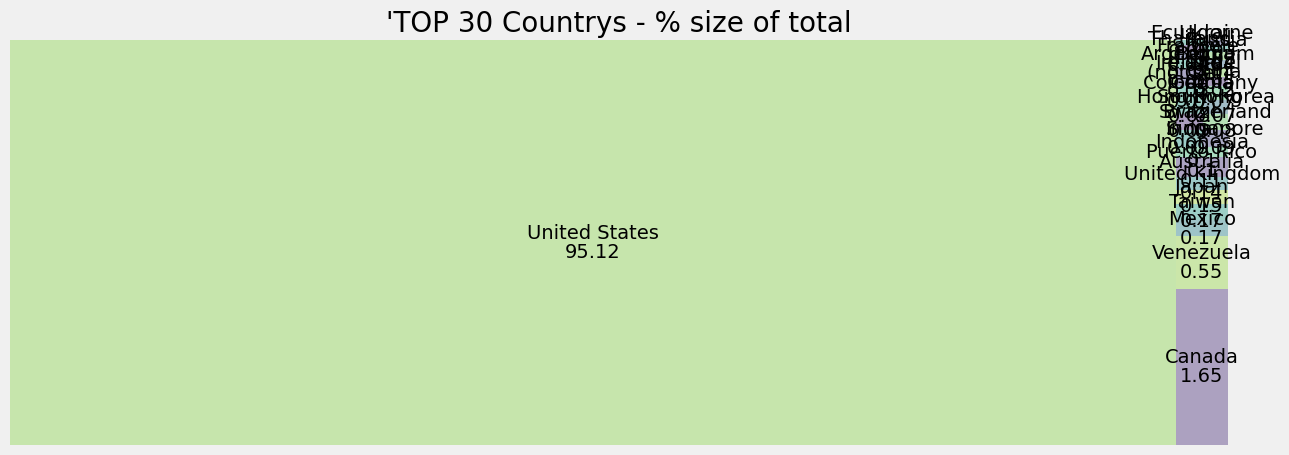

In [89]:
interactive_business_viz(df)

In [90]:
df

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour
752,Direct,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,(not set),0,11,1,4,(direct),(none),True,True,4,2,9,2016,15
753,Organic Search,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),0,10,0,6,google,organic,True,True,4,2,9,2016,15
799,Referral,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),0,11,0,4,mall.googleplex.com,referral,True,True,4,2,9,2016,10
802,Referral,2016-09-02,0185467632009737931,0185467632009737931_1472846398,1472846398,6,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),0,12,0,3,mall.googleplex.com,referral,True,True,4,2,9,2016,15
859,Referral,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),0,14,0,6,mall.googleplex.com,referral,True,True,4,2,9,2016,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,Referral,2017-01-04,6849604863010168468,6849604863010168468_1483566314,1483566314,10,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,(not set),0,48,0,6,mall.googleplex.com,referral,True,True,2,4,1,2017,16
903305,Referral,2017-01-04,0211986650009953276,0211986650009953276_1483568879,1483568879,2,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,Texas,Austin TX,Austin,(not set),0,30,0,6,mall.googleplex.com,referral,True,True,2,4,1,2017,17
903314,Referral,2017-01-04,9981562221973608723,9981562221973608723_1483576938,1483576938,1,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,(not set),0,90,1,3,mall.googleplex.com,referral,False,True,2,4,1,2017,19
903315,Direct,2017-01-04,963126344221316701,963126344221316701_1483552674,1483552674,3,Firefox,Macintosh,False,desktop,Americas,Northern America,United States,New York,New York NY,New York,optonline.net,0,90,0,4,(direct),(none),True,True,2,4,1,2017,12


### Type of data Analysis

Predictive Analysis - Prediction of Revenue Generation by customer

### Categorical Encodings (One hot and label)

In [91]:
# label_encoding(df)

df = encoders(df)
df

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour
752,2,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,2,2,0,0,2,9,66,40,12,2,0,0,11,1,4,0,0,1,1,4,2,9,2016,15
753,4,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,2,3,0,0,2,9,66,48,27,75,0,0,10,0,6,15,5,1,1,4,2,9,2016,15
799,6,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,2,2,0,0,2,9,66,48,27,75,0,0,11,0,4,25,6,1,1,4,2,9,2016,10
802,6,2016-09-02,0185467632009737931,0185467632009737931_1472846398,1472846398,6,2,4,0,0,2,9,66,10,41,71,0,0,12,0,3,25,6,1,1,4,2,9,2016,15
859,6,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,2,3,0,0,2,9,66,78,45,132,0,0,14,0,6,25,6,1,1,4,2,9,2016,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,6,2017-01-04,6849604863010168468,6849604863010168468_1483566314,1483566314,10,2,3,0,0,2,9,66,48,27,75,0,0,48,0,6,25,6,1,1,2,4,1,2017,16
903305,6,2017-01-04,0211986650009953276,0211986650009953276_1483568879,1483568879,2,2,3,0,0,2,9,66,68,2,6,0,0,30,0,6,25,6,1,1,2,4,1,2017,17
903314,6,2017-01-04,9981562221973608723,9981562221973608723_1483576938,1483576938,1,2,3,0,0,3,6,55,59,0,112,0,0,90,1,3,25,6,0,1,2,4,1,2017,19
903315,2,2017-01-04,963126344221316701,963126344221316701_1483552674,1483552674,3,4,3,0,0,2,9,66,48,27,75,449,0,90,0,4,0,0,1,1,2,4,1,2017,12


### Predictors and Target

In [92]:
X = df.drop(['totals.transactionRevenue', 'fullVisitorId', 'sessionId', 'visitId', 'date' ], axis=1)
Y = df['totals.transactionRevenue']

In [93]:
X 

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour
752,2,1,2,2,0,0,2,9,66,40,12,2,0,0,11,1,0,0,1,1,4,2,9,2016,15
753,4,3,2,3,0,0,2,9,66,48,27,75,0,0,10,0,15,5,1,1,4,2,9,2016,15
799,6,7,2,2,0,0,2,9,66,48,27,75,0,0,11,0,25,6,1,1,4,2,9,2016,10
802,6,6,2,4,0,0,2,9,66,10,41,71,0,0,12,0,25,6,1,1,4,2,9,2016,15
859,6,4,2,3,0,0,2,9,66,78,45,132,0,0,14,0,25,6,1,1,4,2,9,2016,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903302,6,10,2,3,0,0,2,9,66,48,27,75,0,0,48,0,25,6,1,1,2,4,1,2017,16
903305,6,2,2,3,0,0,2,9,66,68,2,6,0,0,30,0,25,6,1,1,2,4,1,2017,17
903314,6,1,2,3,0,0,3,6,55,59,0,112,0,0,90,1,25,6,0,1,2,4,1,2017,19
903315,2,3,4,3,0,0,2,9,66,48,27,75,449,0,90,0,0,0,1,1,2,4,1,2017,12


### Correlation Matrix

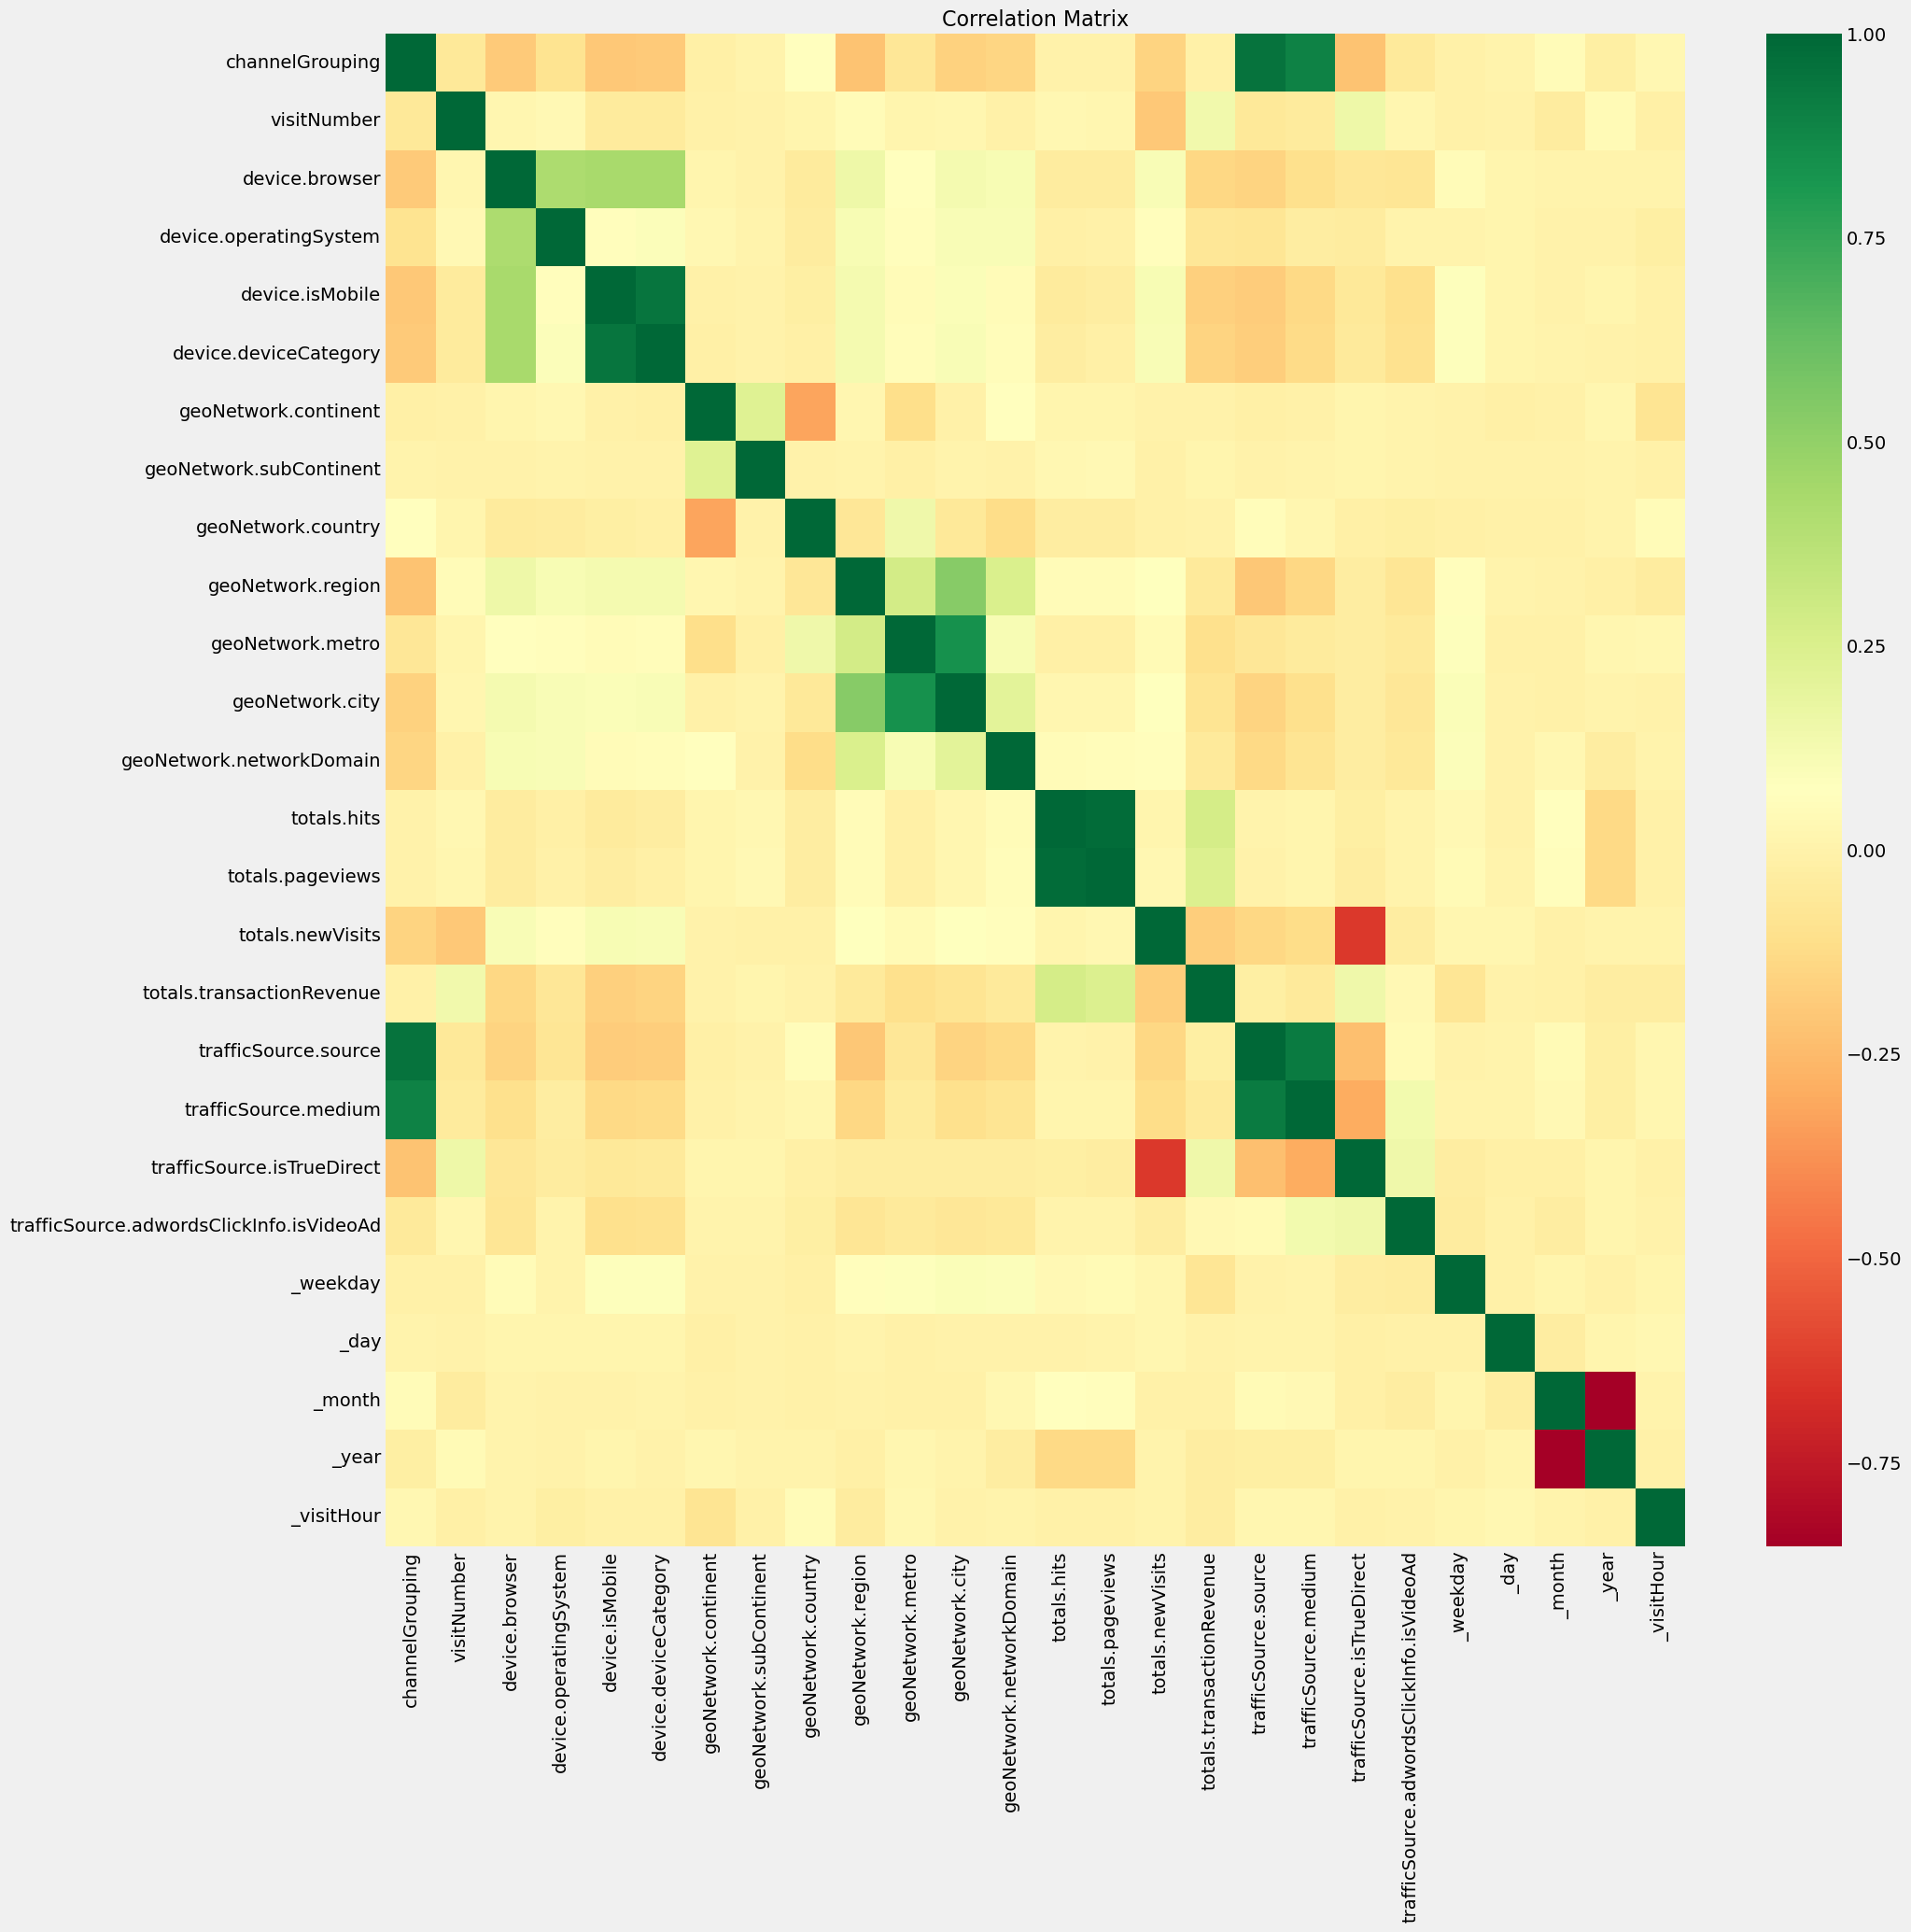

In [94]:
# correlation matrix seaborn
pp = df.drop(['visitId', 'fullVisitorId', 'sessionId', 'date' ], axis=1)
plt.figure(figsize=(20, 20))
sns.heatmap(pp.corr(), annot=False, cmap="RdYlGn")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

### Train Test Split

In [95]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

### Handling Imbalanced Datasets

In [96]:


# # add a column 'non_zero_revenue' to train_df with value 1 if totals.transactionRevenue is non-zero and 0 otherwise
# df['non_zero_revenue'] = np.where(df['totals.transactionRevenue'] > 0, 1, 0)

# from smogn import smoter
# # Oversample df using smoter
# train_df_oversampled = smoter(data=df, y='totals.transactionRevenue')



In [97]:
print(df['totals.transactionRevenue'].value_counts())

3    256
3    189
4    187
4    170
3    135
    ... 
6      1
5      1
5      1
4      1
4      1
Name: totals.transactionRevenue, Length: 5332, dtype: int64


### Over under ssampling or other hybrid approaches such as smotetomek and smotheen 

In [98]:
# oversampling non zero revenue rows

# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, Y)



### Sota Modeling (XGBoost, LGBM, Catboost, Deep learnign architectures, stacking)

In [99]:
## 6min to run on m2 chip
# light gbm

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state":42,
        'max_depth': 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train, lgb_eval])  # You can provide a list of datasets for validation)

# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importance()))


The rmse of prediction is: 1.0553670046738715
Feature importances: [2584, 12817, 1462, 3533, 357, 367, 572, 1143, 2950, 4362, 3863, 6612, 12352, 20630, 17955, 118, 3902, 1092, 1015, 104, 7086, 14576, 10030, 843, 11437]


### LightGBM, XGBoost, Catboost Stacked

In [100]:
## run time 8 mins on m2 chip

def lightGBM_XGB_CatBoost_Stacked_Model(X_train, X_test, y_train, y_test):
    # Split the data for training and validation
    X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # LightGBM
    lgb_train = lgb.Dataset(X_train_stack, y_train_stack)
    lgb_eval = lgb.Dataset(X_val_stack, y_val_stack, reference=lgb_train)

    # Note - hyperparameters are directly added to avoid long processing time for hyperparameter tuning
    lgb_params = {
        'learning_rate': 0.01,
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state": 42,
        'max_depth': 5,
        "bagging_seed": 42,
        "verbosity": -1,
        "bagging_frequency": 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
    }

    lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_eval])

    # XGBoost
    xgb_train = xgb.DMatrix(X_train_stack, label=y_train_stack)
    xgb_val = xgb.DMatrix(X_val_stack, label=y_val_stack)

    xgb_params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma': 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

    xgb_model = xgb.train(xgb_params, xgb_train, num_boost_round=2000, evals=[(xgb_train, 'train'), (xgb_val, 'eval')])

    # CatBoost
    cat_model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.03,
        depth=10,
        eval_metric='RMSE',
        od_type='Iter',
        metric_period=50,
        od_wait=20,
        random_seed=42
    )

    cat_model.fit(X_train_stack, y_train_stack, eval_set=(X_val_stack, y_val_stack))

    # Combine predictions
    lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    xgb_pred = xgb_model.predict(xgb.DMatrix(X_test))
    cat_pred = cat_model.predict(X_test)

    # Simple averaging of predictions
    stacked_pred = (lgb_pred + xgb_pred + cat_pred) / 3

    # Evaluate stacked model
    stacked_rmse = mean_squared_error(y_test, stacked_pred) ** 0.5
    print('The RMSE of the stacked model is:', stacked_rmse)

    return stacked_pred

lightGBM_XGB_CatBoost_Stacked_Model(X_train, X_test, y_train, y_test)


[0]	train-rmse:3.65679	eval-rmse:3.69462
[1]	train-rmse:3.59051	eval-rmse:3.62846
[2]	train-rmse:3.52634	eval-rmse:3.56431
[3]	train-rmse:3.46320	eval-rmse:3.50130
[4]	train-rmse:3.40159	eval-rmse:3.43968
[5]	train-rmse:3.34165	eval-rmse:3.37983
[6]	train-rmse:3.28250	eval-rmse:3.32075
[7]	train-rmse:3.22490	eval-rmse:3.26322
[8]	train-rmse:3.16875	eval-rmse:3.20700
[9]	train-rmse:3.11357	eval-rmse:3.15183
[10]	train-rmse:3.05969	eval-rmse:3.09787
[11]	train-rmse:3.00696	eval-rmse:3.04511
[12]	train-rmse:2.95542	eval-rmse:2.99358
[13]	train-rmse:2.90441	eval-rmse:2.94252
[14]	train-rmse:2.85530	eval-rmse:2.89350
[15]	train-rmse:2.80724	eval-rmse:2.84556
[16]	train-rmse:2.76028	eval-rmse:2.79870
[17]	train-rmse:2.71451	eval-rmse:2.75301
[18]	train-rmse:2.66977	eval-rmse:2.70817
[19]	train-rmse:2.62635	eval-rmse:2.66485
[20]	train-rmse:2.58408	eval-rmse:2.62263
[21]	train-rmse:2.54165	eval-rmse:2.58023
[22]	train-rmse:2.50111	eval-rmse:2.53977
[23]	train-rmse:2.46138	eval-rmse:2.50017
[2

50:	learn: 0.9890373	test: 1.0746847	best: 1.0746847 (50)	total: 416ms	remaining: 3.66s
100:	learn: 0.9326778	test: 1.0560784	best: 1.0560784 (100)	total: 815ms	remaining: 3.22s
150:	learn: 0.9002761	test: 1.0512803	best: 1.0512803 (150)	total: 1.18s	remaining: 2.74s
200:	learn: 0.8743952	test: 1.0476592	best: 1.0475921 (199)	total: 1.54s	remaining: 2.29s
250:	learn: 0.8523488	test: 1.0460651	best: 1.0460571 (242)	total: 2.09s	remaining: 2.07s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.0459716
bestIteration = 253

Shrink model to first 254 iterations.
The RMSE of the stacked model is: 1.0235120966334157


array([4.58215858, 4.65261635, 2.95380143, ..., 3.58258465, 3.2185304 ,
       3.6102438 ])

### Model Evaluations to avoid overfitting and bias )ROC-AUC, .....RMSE, MAE, SR^25

RMSE:  1.0553670046738715
MAE:  0.8224546157660139


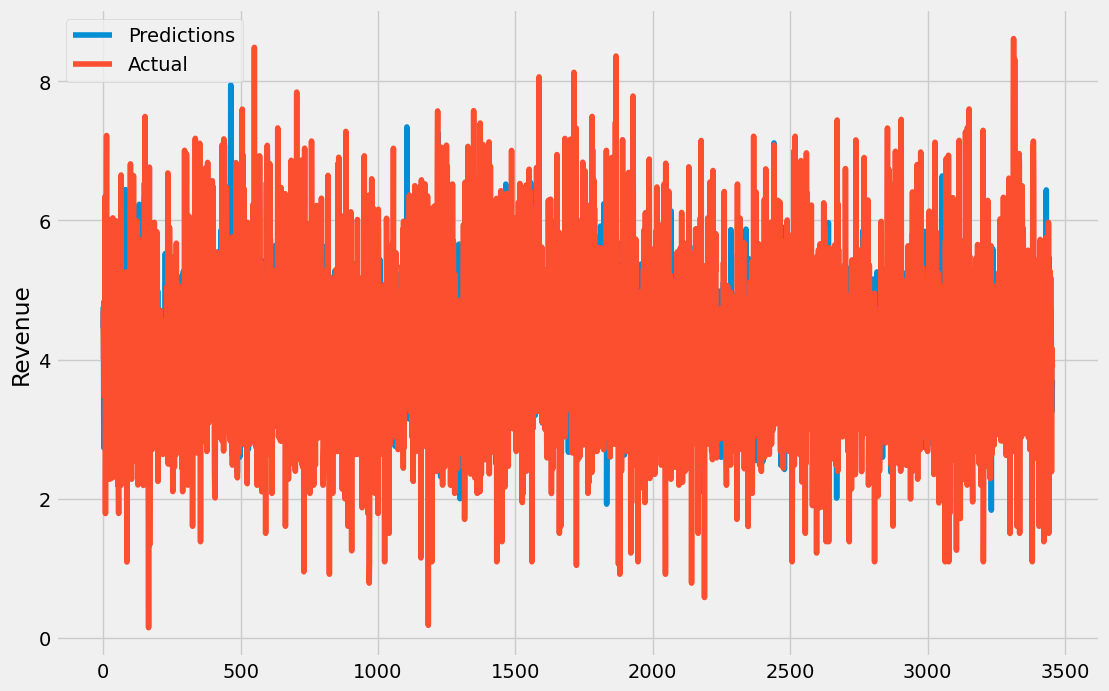

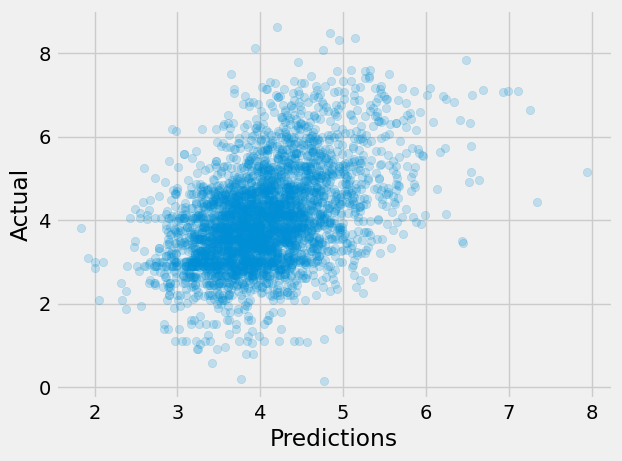

In [101]:
# model evaluations
# RMSE, MAE, R2, RMSLE, SR^25
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print("RMSE: ", RMSE)
print("MAE: ", MAE)


y_pred[y_pred < 0] = 0
# plot predictions and actual values
plt.figure(figsize=(12,8))
plt.plot(y_pred, label='Predictions')
plt.plot(y_test.values, label='Actual')
plt.ylabel('Revenue')
plt.legend()
plt.show()
# make color transparent
plt.scatter(y_pred, y_test, alpha=0.2)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.show()

### Explainability with SHAP or LIME

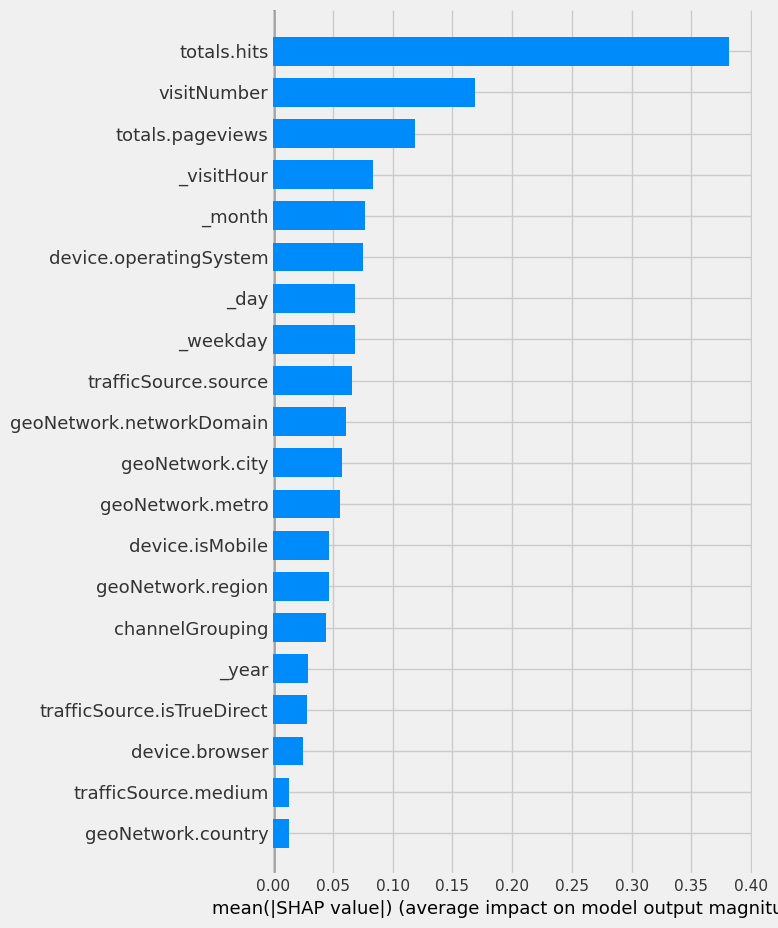

In [102]:
# explainability with SHAP
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Hyper parameter optmization with hyper opt/optuna

In [103]:
# already done in model and commented out to save processing time as it took 7 hours to complete

### Model Persistence

In [104]:
import joblib

joblib.dump(lightGBM_XGB_CatBoost_Stacked_Model, "revenue_prediction_google_analytics.pkl")

['revenue_prediction_google_analytics.pkl']

### Model By Pipeline (uncomment to run)

Same code as above summarized in form of a pipeline

In [105]:

# gaData = pd.read_csv('train_v2.csv', dtype=dtypes, nrows=None)


# transform_pipeline = Pipeline(steps=[
#     ('clean_datatypes', FunctionTransformer(clean_datatypes)),
#     ('fix_nulls', FunctionTransformer(Fixing_Blanks_Nulls)),
#     ('remove_redundant', FunctionTransformer(removing_redundant_columns)),
#     ('normalize', FunctionTransformer(Normalizing)),
#     ('time_related', FunctionTransformer(timerelated_fields)),
#     ('encoders', FunctionTransformer(encoders)),
#     ('remove_columns_not_affecting_prediction', FunctionTransformer(remove_columns_not_affecting_prediction))
# ])

# df_transformed = transform_pipeline.transform(gaData)

# X = df_transformed.drop(['totals.transactionRevenue'], axis=1)
# Y = df_transformed['totals.transactionRevenue']
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

# lightGBM_XGB_CatBoost_Stacked_Model(X_train, X_test, y_train, y_test)

# Causal Inference